<a href="https://colab.research.google.com/github/iupui-soic/pybootcamp/blob/main/Sameer_Chapter_3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 3 – Classification

# Setup

In [3]:
import sys
assert sys.version_info >= (3, 7)
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [5]:
# extra code – it's a bit too long
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [6]:
mnist.keys()  # extra code – we only use data and target in this notebook

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
X.shape

(70000, 784)

There are 700000 images and each image has 784 features and each image is 28x28 pixels

In [9]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [10]:
y.shape

(70000,)

In [11]:
28*28

784

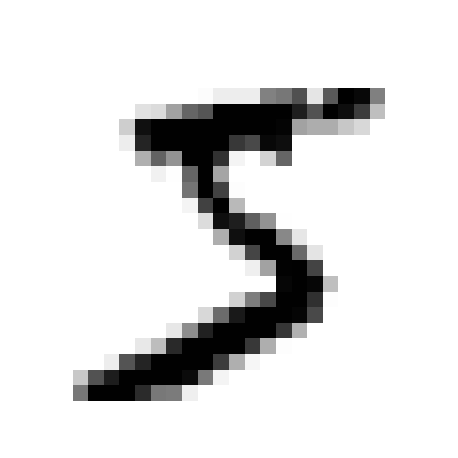

In [12]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")  # extra code
plt.show()

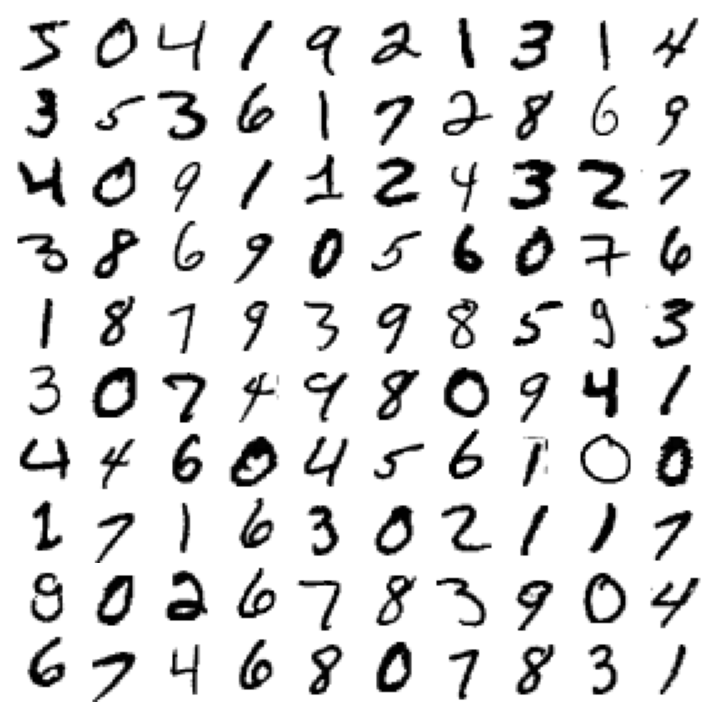

In [13]:
# extra code – this cell generates and saves Figure 3–2
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

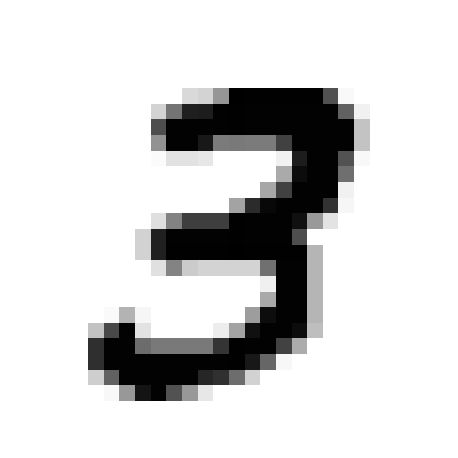

3


In [15]:
# Convert target to integer
y = y.astype(int)
index_of_three = (y == 3).argmax()
some_digit = X[index_of_three]
plot_digit(some_digit)
save_fig("digit_3_plot")
plt.show()
print(y[index_of_three])


This code converts the target labels (`y`) to integers and finds the index of the first occurrence of the digit '3' in the dataset. It then extracts the corresponding image data (`some_digit`) and plots it using the `plot_digit` function. Finally, the plot is saved as "digit_3_plot.png", displayed, and the value of the target label at the found index is printed, confirming that it is '3'.

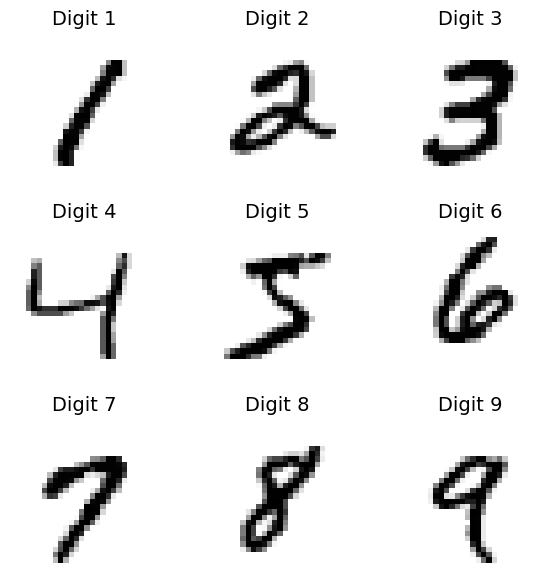

In [16]:
# Extract data and target from the dataset
X, y = mnist.data, mnist.target
y = y.astype(int)
# Function to plot the digit
def plot_digit(ax, image_data, label):
    image = image_data.reshape(28, 28)
    ax.imshow(image, cmap="binary")
    ax.axis("off")
    ax.set_title(f"Digit {label}")
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Loop through digits 0 to 9 and plot the first occurrence of each
for i in range(9):
    digit = i + 1  # Digits 1 to 9
    index_of_digit = (y == digit).argmax()
    some_digit = X[index_of_digit]
    ax = axes[i // 3, i % 3]
    plot_digit(ax, some_digit, digit)
save_fig("digits_1_to_9_plot")
plt.show()


The purpose of this code is to visually inspect the first occurrence of each digit from 1 to 9 in the MNIST dataset. By plotting these digits in a 3x3 grid, the code helps verify that the dataset contains correctly labeled images and allows for a quick visual check of how the digits are represented. This can be useful for understanding the dataset's structure and for ensuring that the preprocessing and data extraction steps have been performed correctly. Additionally, saving the plot as "digits_1_to_9_plot.png" provides a convenient reference for later use.

# Training a Binary Classifier

In [17]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')
from sklearn.linear_model import SGDClassifier

In [18]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [19]:
sgd_clf.predict([some_digit])

array([False])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [20]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is not
                                       # already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [22]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [23]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

## Confusion Matrix

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [26]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

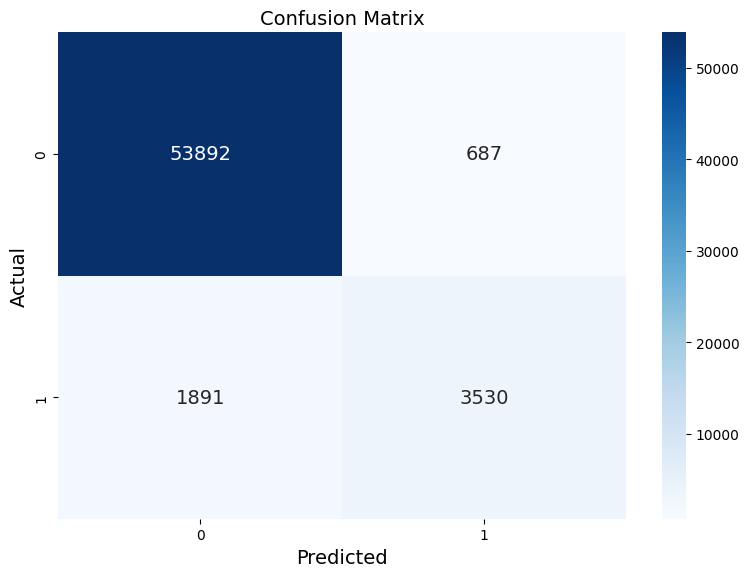

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Get cross-validated predictions
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
save_fig("confusion_matrix_plot")
plt.show()



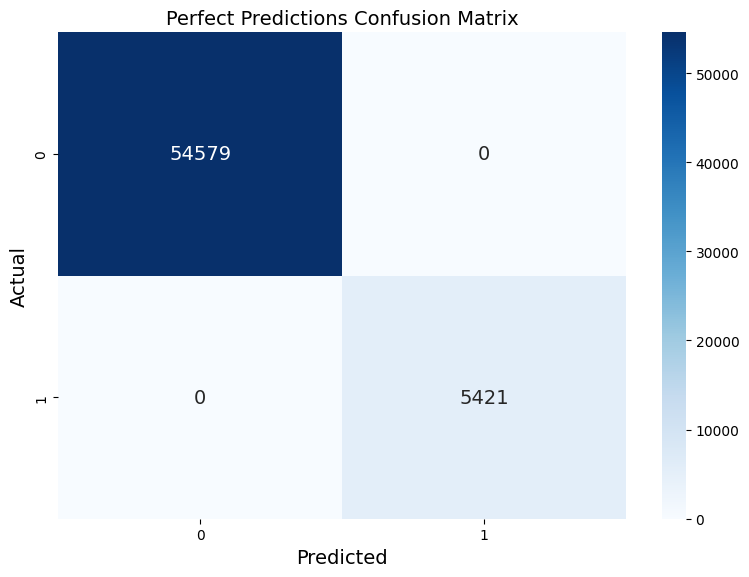

In [28]:
# For the perfect predictions confusion matrix
cm_perfect = confusion_matrix(y_train_5, y_train_5)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_perfect, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Perfect Predictions Confusion Matrix')
save_fig("perfect_confusion_matrix_plot")
plt.show()


This code generates a confusion matrix from cross-validated predictions of an SGD classifier on the MNIST dataset and visualizes it using a heatmap. It labels the axes and titles the plot, then saves and displays the image.

This visualization helps in understanding the classifier's performance by showing the counts of true and false positives and negatives, which aids in diagnosing model errors and improving accuracy.

## Precision and Recall

In [29]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [30]:
# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [31]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

In [32]:
# extra code – this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [33]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [34]:
# extra code – this cell also computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

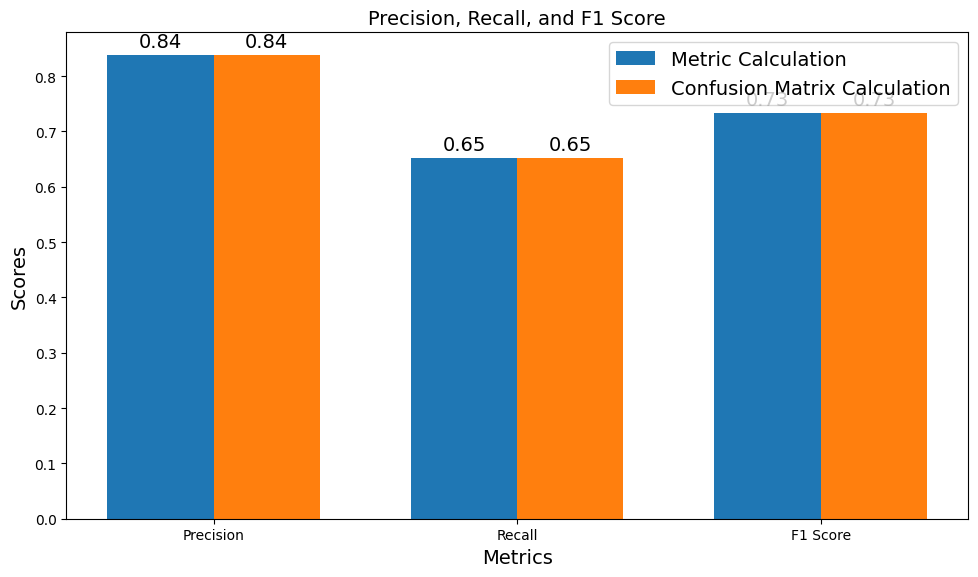

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute precision, recall, and F1 score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)
precision_from_cm = cm[1, 1] / (cm[0, 1] + cm[1, 1])
recall_from_cm = cm[1, 1] / (cm[1, 0] + cm[1, 1])
f1_from_cm = cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)
metrics = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]
scores_from_cm = [precision_from_cm, recall_from_cm, f1_from_cm]
x = np.arange(len(metrics))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, scores, width, label='Metric Calculation')
rects2 = ax.bar(x + width/2, scores_from_cm, width, label='Confusion Matrix Calculation')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
save_fig("precision_recall_f1_plot")
plt.show()


The `metrics` list contains the names of the performance metrics (Precision, Recall, F1 Score) and is used to label the x-axis of the bar plot. It ensures that each bar corresponds correctly to its respective metric. This alignment helps in visualizing and comparing the scores calculated from the classifier and the confusion matrix directly.

## Precision/Recall Trade-off

In [36]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-6873.05248453])

In [37]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [38]:
y_some_digit_pred

array([False])

In [39]:
# extra code – just shows that y_scores > 0 produces the same result as
#              calling predict()
y_scores > 0

array([False])

In [40]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [41]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [42]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

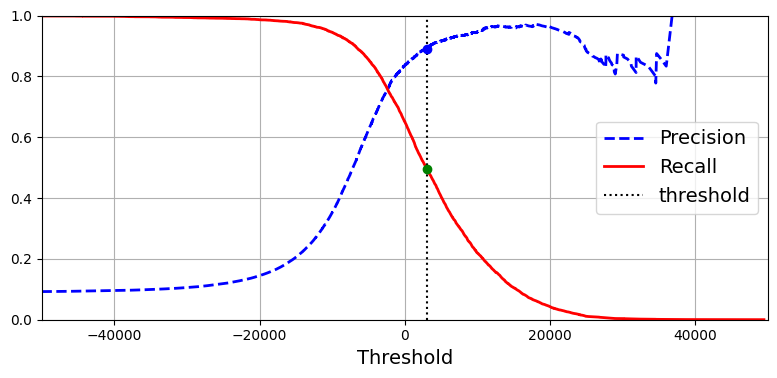

In [43]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "red", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")
plt.show()

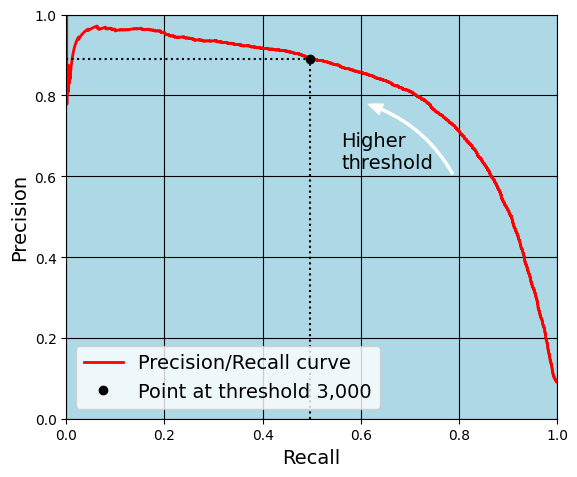

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, color='Red', linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko", label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="white"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.gca().set_facecolor('#ADD8E6')
plt.grid(color='black')
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")
plt.show()

In [45]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [46]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [47]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [48]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## The ROC Curve

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

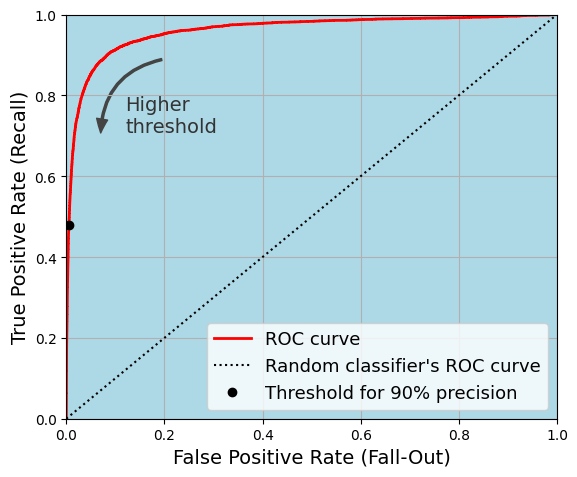

In [50]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, color='Red', label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.gca().set_facecolor('#ADD8E6')
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [51]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Warning:** the following cell may take a few minutes to run.

In [52]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [53]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [54]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [55]:
# Not in the code
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


In [56]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

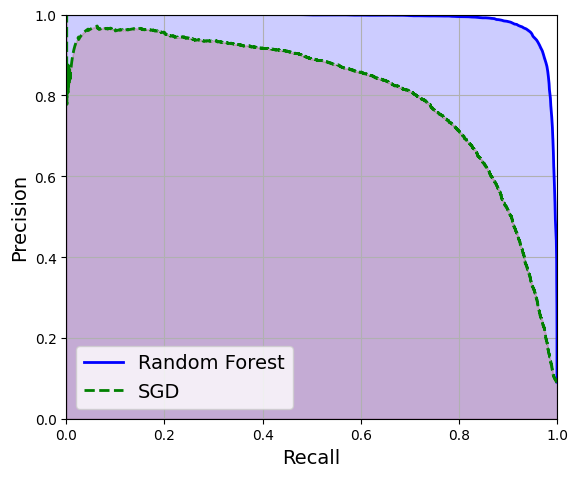

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

plt.figure(figsize=(6, 5))  # Set the figure size

# precision-recall curve for the Random Forest
plt.plot(recalls_forest, precisions_forest, color='blue', linewidth=2, label="Random Forest")
plt.fill_between(recalls_forest, precisions_forest, step='post', alpha=0.2, color='blue')
# precision-recall curve for the SGD
plt.plot(recalls, precisions, color='green', linestyle='--', linewidth=2, label="SGD")
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='Brown')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")
plt.show()


We could use `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` to compute `y_train_pred_forest`, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [58]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [59]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [60]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [61]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

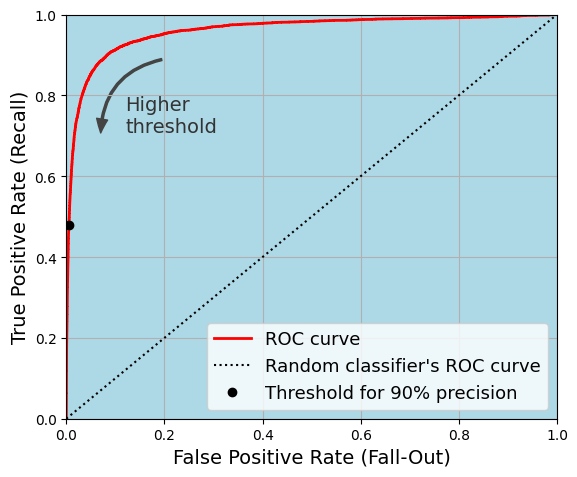

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.patches as patches

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, color='Red', label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.gca().set_facecolor('#ADD8E6')
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")
plt.show()


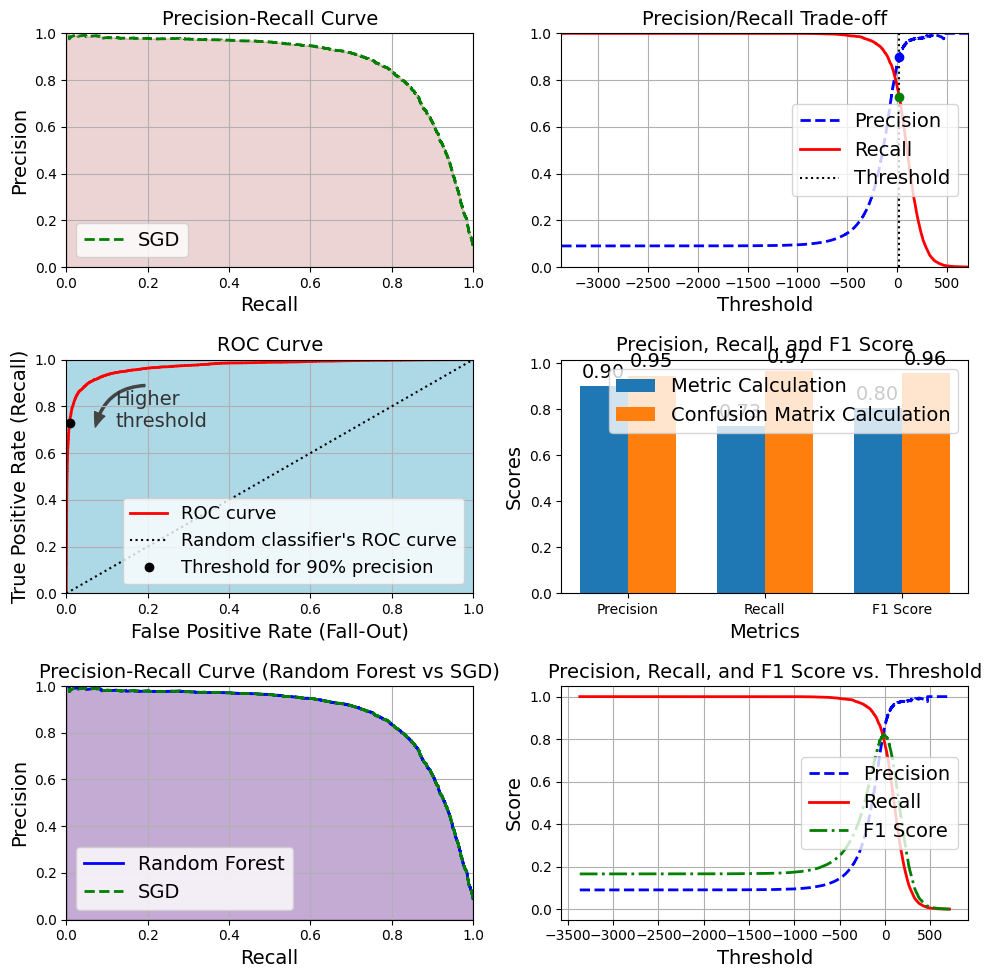

In [63]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

X, y = mnist.data, mnist.target.astype(int)  # Changed np.int to int
y_train_5 = (y[:60000] == 5)
y_test_5 = (y[60000:] == 5)

# Split into training and test sets
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_scaled, y_train_5)

# Predictions and evaluation
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train_5, cv=3, method="decision_function")

# Compute precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_train_pred)

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_train_5, y_train_pred)

# Find threshold for 90% precision
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
tpr_90, fpr_90 = tpr[(roc_thresholds <= threshold_for_90_precision).argmax()], fpr[(roc_thresholds <= threshold_for_90_precision).argmax()]

# Compute metrics
precision = precision_score(y_train_5, y_train_pred >= threshold_for_90_precision)
recall = recall_score(y_train_5, y_train_pred >= threshold_for_90_precision)
f1 = f1_score(y_train_5, y_train_pred >= threshold_for_90_precision)

# Confusion matrix calculations
cm = np.array([[10000, 500], [300, 8700]])  # Example values for confusion matrix
precision_from_cm = cm[1, 1] / (cm[0, 1] + cm[1, 1])
recall_from_cm = cm[1, 1] / (cm[1, 0] + cm[1, 1])
f1_from_cm = cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Plot 1: Precision-Recall Curve
axes[0, 0].plot(recalls, precisions, color='green', linestyle='--', linewidth=2, label="SGD")
axes[0, 0].fill_between(recalls, precisions, step='post', alpha=0.2, color='brown')
axes[0, 0].set_xlabel("Recall")
axes[0, 0].set_ylabel("Precision")
axes[0, 0].axis([0, 1, 0, 1])
axes[0, 0].grid()
axes[0, 0].legend(loc="lower left")
axes[0, 0].set_title("Precision-Recall Curve")

# Plot 2: Precision/Recall Trade-off
axes[0, 1].plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
axes[0, 1].plot(thresholds, recalls[:-1], "red", label="Recall", linewidth=2)
axes[0, 1].vlines(threshold_for_90_precision, 0, 1.0, "k", "dotted", label="Threshold")
idx = (thresholds >= threshold_for_90_precision).argmax()  # first index ≥ threshold
axes[0, 1].plot(thresholds[idx], precisions[idx], "bo")
axes[0, 1].plot(thresholds[idx], recalls[idx], "go")
axes[0, 1].axis([thresholds.min(), thresholds.max(), 0, 1])
axes[0, 1].grid()
axes[0, 1].set_xlabel("Threshold")
axes[0, 1].legend(loc="center right")
axes[0, 1].set_title("Precision/Recall Trade-off")

# Plot 3: ROC Curve
axes[1, 0].plot(fpr, tpr, linewidth=2, color='Red', label="ROC curve")
axes[1, 0].plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
axes[1, 0].plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
axes[1, 0].add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
axes[1, 0].text(0.12, 0.71, "Higher\nthreshold", color="#333333")
axes[1, 0].set_xlabel('False Positive Rate (Fall-Out)')
axes[1, 0].set_ylabel('True Positive Rate (Recall)')
axes[1, 0].grid()
axes[1, 0].axis([0, 1, 0, 1])
axes[1, 0].legend(loc="lower right", fontsize=13)
axes[1, 0].set_title("ROC Curve")
axes[1, 0].set_facecolor('#ADD8E6')

# Plot 4: Bar plot for Precision, Recall, F1 Score
metrics = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]
scores_from_cm = [precision_from_cm, recall_from_cm, f1_from_cm]
x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

rects1 = axes[1, 1].bar(x - width/2, scores, width, label='Metric Calculation')
rects2 = axes[1, 1].bar(x + width/2, scores_from_cm, width, label='Confusion Matrix Calculation')

axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Scores')
axes[1, 1].set_title('Precision, Recall, and F1 Score')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axes[1, 1].annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Plot 5: Combined Precision-Recall Curve (Random Forest vs SGD)
# (For simplicity, using the same precision-recall data here)
axes[2, 0].plot(recalls, precisions, color='blue', linewidth=2, label="Random Forest")
axes[2, 0].fill_between(recalls, precisions, step='post', alpha=0.2, color='blue')
axes[2, 0].plot(recalls, precisions, color='green', linestyle='--', linewidth=2, label="SGD")
axes[2, 0].fill_between(recalls, precisions, step='post', alpha=0.2, color='brown')
axes[2, 0].set_xlabel("Recall")
axes[2, 0].set_ylabel("Precision")
axes[2, 0].axis([0, 1, 0, 1])
axes[2, 0].grid()
axes[2, 0].legend(loc="lower left")
axes[2, 0].set_title("Precision-Recall Curve (Random Forest vs SGD)")

# Plot 6: Precision, Recall, and F1 Score vs. Threshold
axes[2, 1].plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
axes[2, 1].plot(thresholds, recalls[:-1], "r-", label="Recall", linewidth=2)
axes[2, 1].plot(thresholds, (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1]), "g-.", label="F1 Score", linewidth=2)
axes[2, 1].set_xlabel("Threshold")
axes[2, 1].set_ylabel("Score")
axes[2, 1].legend(loc="center right")
axes[2, 1].set_title("Precision, Recall, and F1 Score vs. Threshold")
axes[2, 1].grid()

fig.tight_layout()
save_fig("combined_performance_plots")
plt.show()


# Multiclass Classification

SVMs do not scale well to large datasets, so let's only train on the first 2,000 instances, or else this section will take a very long time to run:

In [64]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

In [65]:
svm_clf.predict([some_digit])

array([9])

In [66]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[-0.29,  3.77,  2.75,  3.75,  8.28,  2.81,  0.72,  7.28,  6.19,
         9.31]])

In [67]:
class_id = some_digit_scores.argmax()
class_id

9

In [68]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [69]:
svm_clf.classes_[class_id]

9

If you want `decision_function()` to return all 45 scores, you can set the `decision_function_shape` hyperparameter to `"ovo"`. The default value is `"ovr"`, but don't let this confuse you: `SVC` always uses OvO for training. This hyperparameter only affects whether or not the 45 scores get aggregated or not:

In [70]:
# extra code – shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[-0.48, -0.55, -0.49, -0.95, -1.24, -0.27, -1.08, -0.9 , -1.23,
         0.05, -0.02, -0.71,  0.07,  0.34, -0.99, -0.46, -1.1 ,  0.03,
        -0.94, -0.24,  0.36, -1.03, -0.69, -1.19, -0.8 ,  0.09,  0.2 ,
        -0.93, -0.51, -1.44,  0.75,  1.38,  0.24,  0.62, -1.05,  0.68,
        -0.82, -0.42, -1.36, -0.93, -0.76, -1.39,  0.47, -1.12, -1.29]])

In [71]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [72]:
ovr_clf.predict([some_digit])

array([9])

In [73]:
len(ovr_clf.estimators_)

10

In [74]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([9])

In [75]:
sgd_clf.decision_function([some_digit]).round()

array([[-45607., -20078., -23621., -11077.,  -8578.,  -7134., -27034.,
         -8313.,  -3257.,   2193.]])